# Analysis of Crime occurence in Vancouver City from 2013 to 2022
#### University of British Columbia
#### ECON 323-004 2022W2 Final Project 

Collabrators and Contributions:
- Yiming Li(Student number: 52680360): I am accountable for ideating the overarching
concept of the project, formulating the research objectives, and leveraging python code
to construct and evaluate the time series model.
- Pengchao Chen(Student number: 31253933): I contributed to the project by coding and
writing content, as well as building and selecting models.
- Sawyer Wang(Student number: 63591192): Providing the draft of proposal, searching
the datafile and taking the responsibility of cleaning data and representing data.
- Zhihao Wu(Student number: 56834187): Writing the introduction and conclusion, helping
modify the code and annotate the coding.


### 1. Introduction:

In [ ]:
eeeee

### 2. Literature Review:

### 3. Data Pre-Processing

#### A) Load Dataset

In [1]:
# Load package
import pandas as pd
import numpy as np
from pyproj import Proj
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter1d

In [2]:
# Load dataset
df_original = pd.read_csv('crimedata_csv_AllNeighbourhoods_AllYears.csv')
df_original.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Other Theft,2015,5,7,12,50,7XX DUNSMUIR ST,Central Business District,491511.6366,5.459024e+06
1,Other Theft,2015,5,13,17,0,7XX DUNSMUIR ST,Central Business District,491511.6366,5.459024e+06
2,Other Theft,2015,5,16,10,45,7XX DUNSMUIR ST,Central Business District,491511.6366,5.459024e+06
3,Other Theft,2015,5,17,18,45,7XX DUNSMUIR ST,Central Business District,491511.6366,5.459024e+06
4,Other Theft,2015,5,18,20,10,7XX DUNSMUIR ST,Central Business District,491511.6366,5.459024e+06


In [3]:
# Print out the column names, their data types, and count of non-NA values
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857259 entries, 0 to 857258
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           857259 non-null  object 
 1   YEAR           857259 non-null  int64  
 2   MONTH          857259 non-null  int64  
 3   DAY            857259 non-null  int64  
 4   HOUR           857259 non-null  int64  
 5   MINUTE         857259 non-null  int64  
 6   HUNDRED_BLOCK  857247 non-null  object 
 7   NEIGHBOURHOOD  857116 non-null  object 
 8   X              857186 non-null  float64
 9   Y              857186 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 65.4+ MB


In [4]:
# Check if the dataset contains any missing value
df_original.isnull().values.any()

True

In [5]:
# Count the number of missing values for each column
df_original.isnull().sum()

TYPE               0
YEAR               0
MONTH              0
DAY                0
HOUR               0
MINUTE             0
HUNDRED_BLOCK     12
NEIGHBOURHOOD    143
X                 73
Y                 73
dtype: int64

#### B) Data Wrangling

In [6]:
# Drop the rows of missing values and check again if the dataset still contains missing value
df_new = df_original.dropna()
df_new.isnull().values.any()

False

In [7]:
# Drop Day, Hour, Minute columns
df = df_new.drop(columns=['DAY','HOUR','MINUTE'])                       

In [8]:
# Convet UTM zone 10 coordinates in columns "X" and "Y" to latitute and longitude
myProj = Proj(proj='utm',zone=10,ellps='WGS84', preserve_units=False)
LONGITUDE, LATITUDE= myProj(df['X'].values, df['Y'].values, inverse=True)
df["LATITUDE"] = LATITUDE
df["LONGITUDE"] = LONGITUDE

# Drop "X" and "Y" Columns
df = df.drop(columns=['X', 'Y'])

# Create a new column "Coordinates" to zip the latitude and longtitude together
df["COORDINATES"] = list(zip(df.LATITUDE, df.LONGITUDE))
df.head()

,TYPE,YEAR,MONTH,HUNDRED_BLOCK,NEIGHBOURHOOD,LATITUDE,LONGITUDE,COORDINATES
0,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)"
1,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)"
2,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)"
3,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)"
4,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)"


In [9]:
# Create a list of tuples containing the neighborhood and its corresponding area(East, West, Central)
neighborhoods = [
    ('Arbutus Ridge', 'West'),
    ('Dunbar-Southlands', 'West'),
    ('Kerrisdale', 'West'),
    ('Kitsilano', 'West'),
    ('Marpole', 'West'),
    ('West Point Grey', 'West'),
    ('Central Business District', 'Central'),
    ('Fairview', 'Central'),
    ('Oakridge', 'Central'),
    ('Shaughnessy', 'Central'),
    ('South Cambie', 'Central'),
    ('Stanley Park', 'Central'),
    ('West End', 'Central'),
    ('Grandview-Woodland', 'East'),
    ('Hastings-Sunrise', 'East'),
    ('Kensington-Cedar Cottage', 'East'),
    ('Killarney', 'East'),
    ('Mount Pleasant', 'East'),
    ('Musqueam', 'East'),
    ('Renfrew-Collingwood', 'East'),
    ('Riley Park', 'East'),
    ('Strathcona', 'East'),
    ('Sunset', 'East'),
    ('Victoria-Fraserview', 'East')
]

In [10]:
# Create a dictionary to store the neighborhoods by area
neighborhoods_by_area = {}

# Loop through the list of tuples and add neighborhoods to the new dictionary
for neighborhood, area in neighborhoods:
    neighborhoods_by_area[neighborhood] = area

# Replace neighborhood names with area names
df['AREA'] = df['NEIGHBOURHOOD'].map(neighborhoods_by_area)

# Select 11 Year from the whole data frame
df_12 = df[df["YEAR"] > 2011]
df_12_22 = df_12[df_12["YEAR"] < 2023]

# Show the clean data
df_12_22.head()

,TYPE,YEAR,MONTH,HUNDRED_BLOCK,NEIGHBOURHOOD,LATITUDE,LONGITUDE,COORDINATES,AREA
0,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)",Central
1,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)",Central
2,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)",Central
3,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)",Central
4,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)",Central


### 4.  Exploratory Data Analysis:

#### A) Summary View

In [12]:
# Summary table of dataset
df.describe()

,YEAR,MONTH,LATITUDE,LONGITUDE
count,857104.000000,857104.000000,857104.000000,857104.000000
mean,2011.982275,6.499985,44.973411,-123.488727
std,6.010221,3.418684,13.891478,1.236014
min,2003.000000,1.000000,0.000000,-127.488744
25%,2006.000000,4.000000,49.240650,-123.134873
50%,2012.000000,7.000000,49.267138,-123.115943
75%,2017.000000,9.000000,49.281197,-123.090920
max,2023.000000,12.000000,49.313349,-123.022987


viz:
bar chart - count / percentage of crime

map - number of crime in map

pie - type of crime in each area

line graphs - count of crime in different years for each area

pivot table - Which months have the highest and lowest average number crimes?\

heat map  - Trend within the year? - heatmap with months and categories 

### 5. Empirical Analysis

In [23]:
# Sum different crime cases in each month
df_new = df_12_22.groupby(['TYPE', 'YEAR', 'MONTH', 'AREA']).size().reset_index(name='COUNT')

df_new.head()

,TYPE,YEAR,MONTH,AREA,COUNT
0,Break and Enter Commercial,2012,1,Central,96
1,Break and Enter Commercial,2012,1,East,52
2,Break and Enter Commercial,2012,1,West,8
3,Break and Enter Commercial,2012,2,Central,61
4,Break and Enter Commercial,2012,2,East,38


#### Seperate into Three data frame by area

In [13]:
# Combine the year and month, and make it to a new column
df_new = df_new.reset_index(drop = True)
df_new['DATE'] = df_new['YEAR'].astype(str) + '-' + df_new['MONTH'].astype(str)

# Set date to index
df_new = df_new.set_index('DATE')

# Central
df_central = df_new[df_new['AREA'] == "Central"]
# East
df_east = df_new[df_new["AREA"] == "East"]
# West
df_west = df_new[df_new["AREA"] == "West"]

##### West

In [14]:
# Remove unuseful columns: "YEAR", "MONTH" and "AREA"
df_west = df_west.drop(columns = ['YEAR', 'MONTH', 'AREA'])   
df_west.head()

,TYPE,COUNT
DATE,,
2012-1,Break and Enter Commercial,8
2012-2,Break and Enter Commercial,19
2012-3,Break and Enter Commercial,15
2012-4,Break and Enter Commercial,14
2012-5,Break and Enter Commercial,7


Plot each crime types in west area from 2012 to 2022

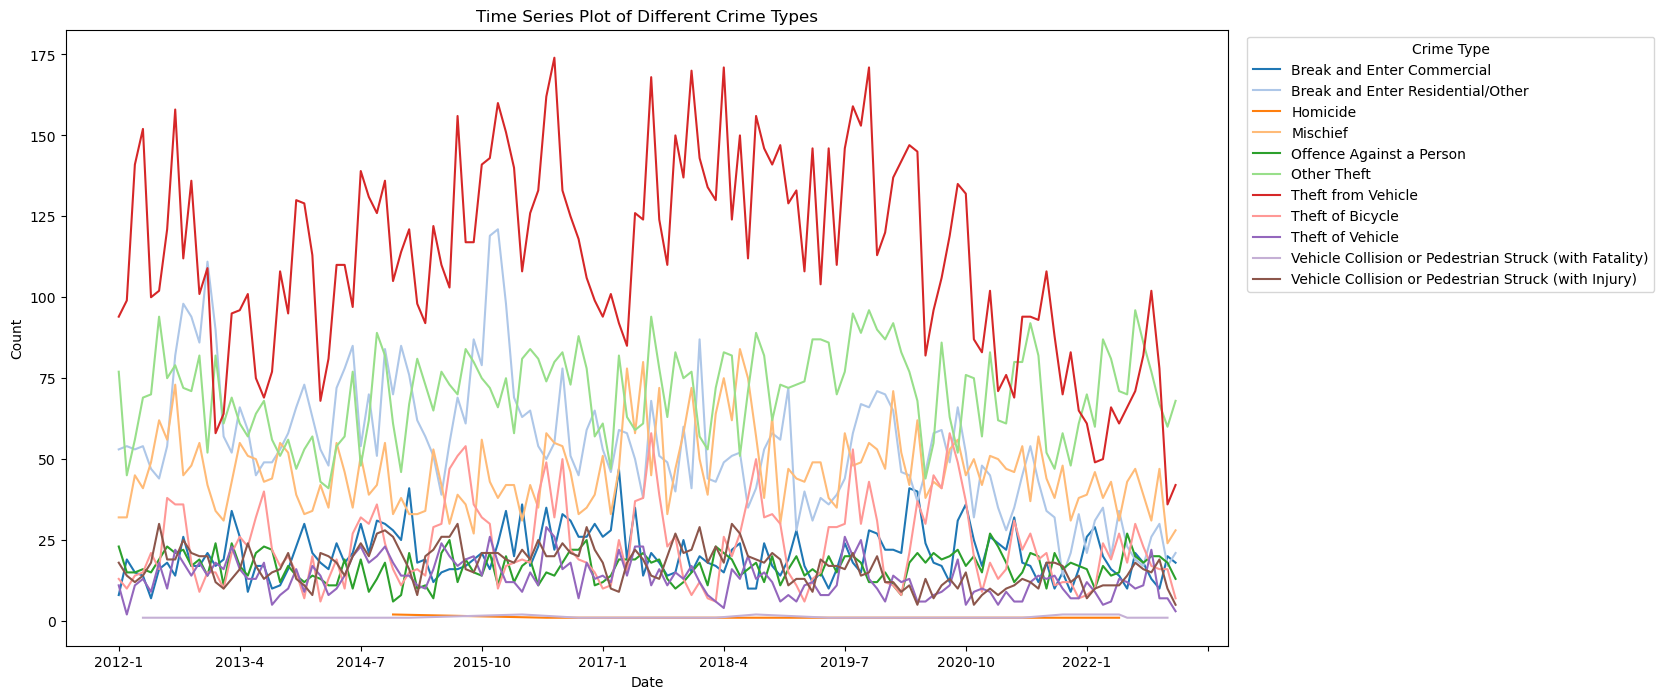

In [15]:
# Create a custom color palette
num_colors = 11  # Adjust this number based on the number of crime types
color_palette = cm.tab20.colors[:num_colors]

# Create a time series plot with multiple crime types (without points)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_west, x='DATE', y='COUNT', hue='TYPE', palette=color_palette)

# Set the x-axis date format and number of ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot of Different Crime Types')
plt.legend(title='Crime Type')

plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')

Plot smoothed time series plot of West area

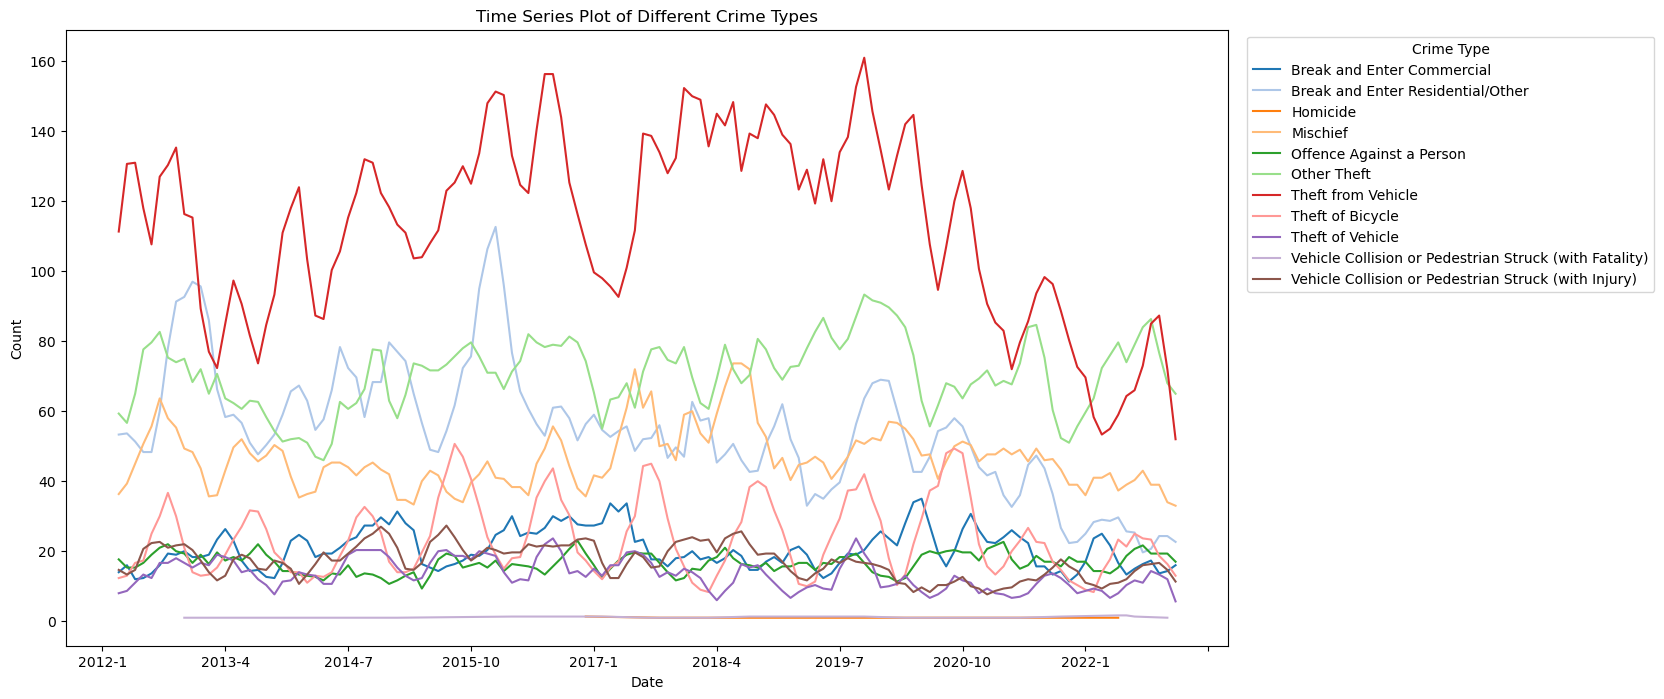

In [16]:
# Using moving average where lag = 3
df_west_smoothed = df_west.groupby(['TYPE']).rolling(window=3).mean()
df_west_smoothed.reset_index(inplace=True)

# Create a smoothed time series plot with multiple crime types (without points)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_west_smoothed, x='DATE', y='COUNT', hue='TYPE', palette=color_palette, estimator='mean')

# Set the x-axis date format and number of ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot of Different Crime Types')
plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')

##### East

In [17]:
# Remove unuseful columns: "YEAR", "MONTH" and "AREA"
df_east = df_east.drop(columns = ['YEAR', 'MONTH', 'AREA'])   
df_east.head()

,TYPE,COUNT
DATE,,
2012-1,Break and Enter Commercial,52
2012-2,Break and Enter Commercial,38
2012-3,Break and Enter Commercial,73
2012-4,Break and Enter Commercial,70
2012-5,Break and Enter Commercial,60


Plot each crime types in east area from 2012 to 2022

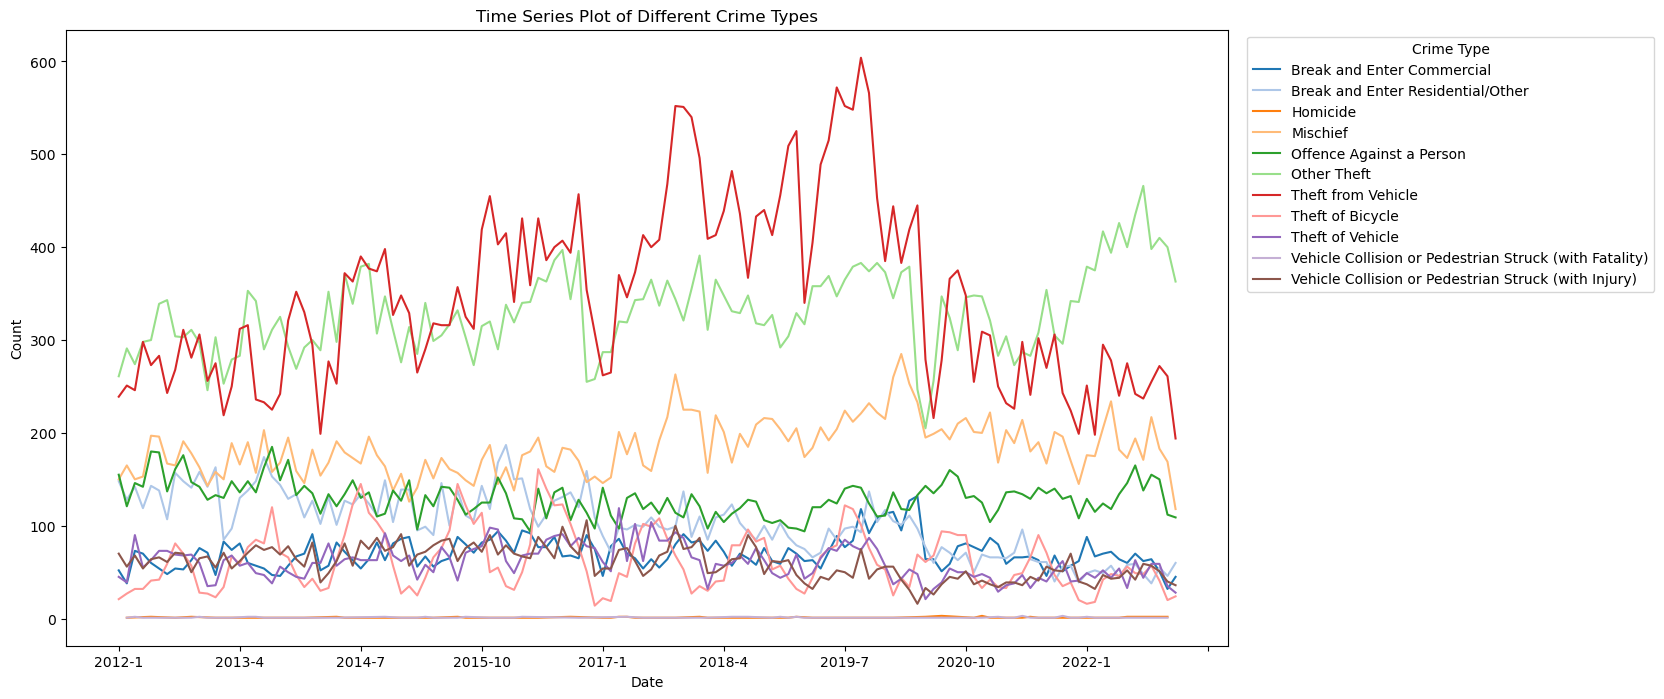

In [18]:
# Create a time series plot with multiple crime types (without points)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_east, x='DATE', y='COUNT', hue='TYPE', palette=color_palette)

# Set the x-axis date format and number of ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot of Different Crime Types')
plt.legend(title='Crime Type')

plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')

Plot smoothed time series plot of East area

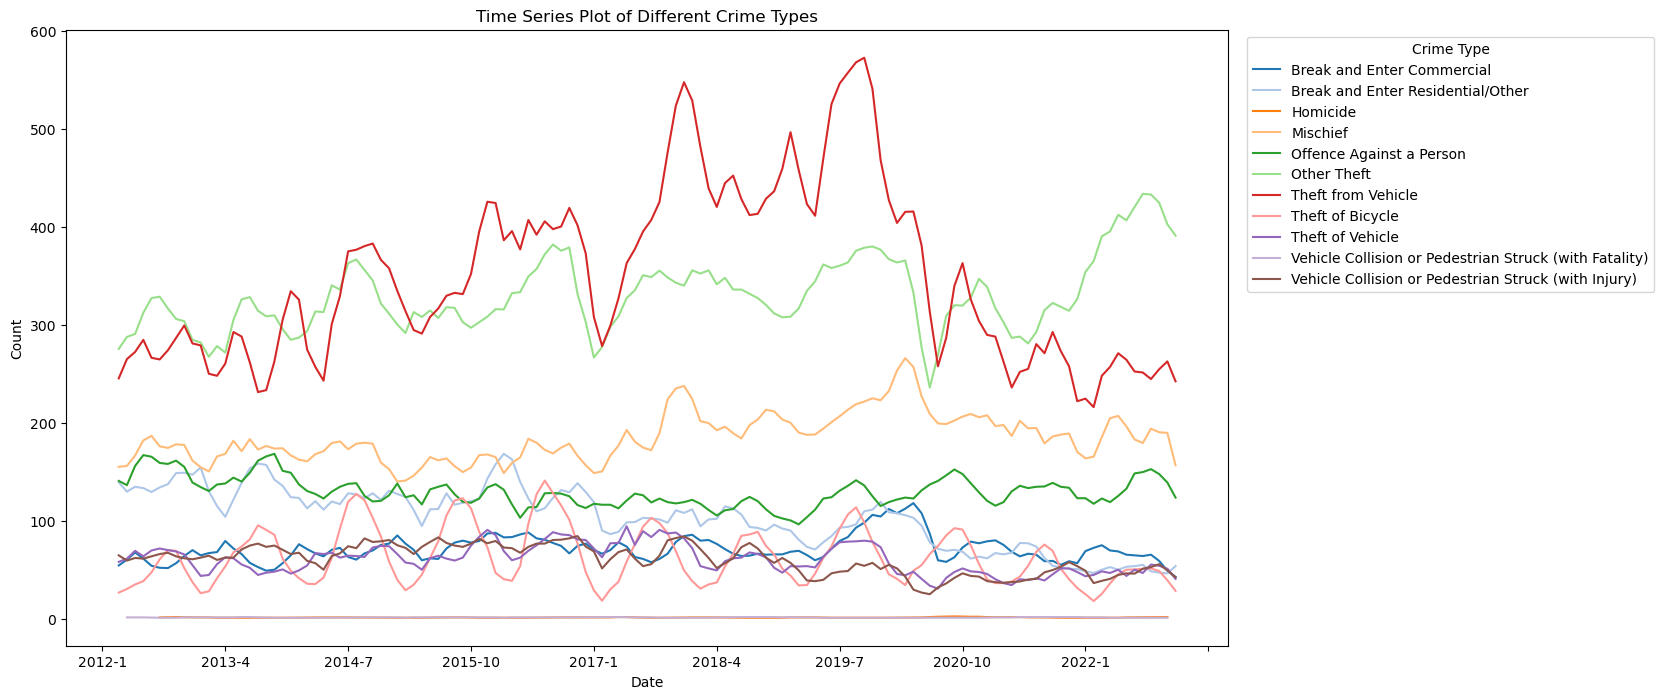

In [19]:
# Using moving average where lag = 3
df_east_smoothed = df_east.groupby(['TYPE']).rolling(window=3).mean()
df_east_smoothed.reset_index(inplace=True)

# Create a smoothed time series plot with multiple crime types (without points)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_east_smoothed, x='DATE', y='COUNT', hue='TYPE', palette=color_palette, estimator='mean')

# Set the x-axis date format and number of ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot of Different Crime Types')
plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')

##### Central

In [20]:
# Remove unuseful columns: "YEAR", "MONTH" and "AREA"
df_central = df_central.drop(columns = ['YEAR', 'MONTH', 'AREA'])   
df_central.head()

,TYPE,COUNT
DATE,,
2012-1,Break and Enter Commercial,96
2012-2,Break and Enter Commercial,61
2012-3,Break and Enter Commercial,77
2012-4,Break and Enter Commercial,71
2012-5,Break and Enter Commercial,66


Plot each crime types in central area from 2012 to 2022

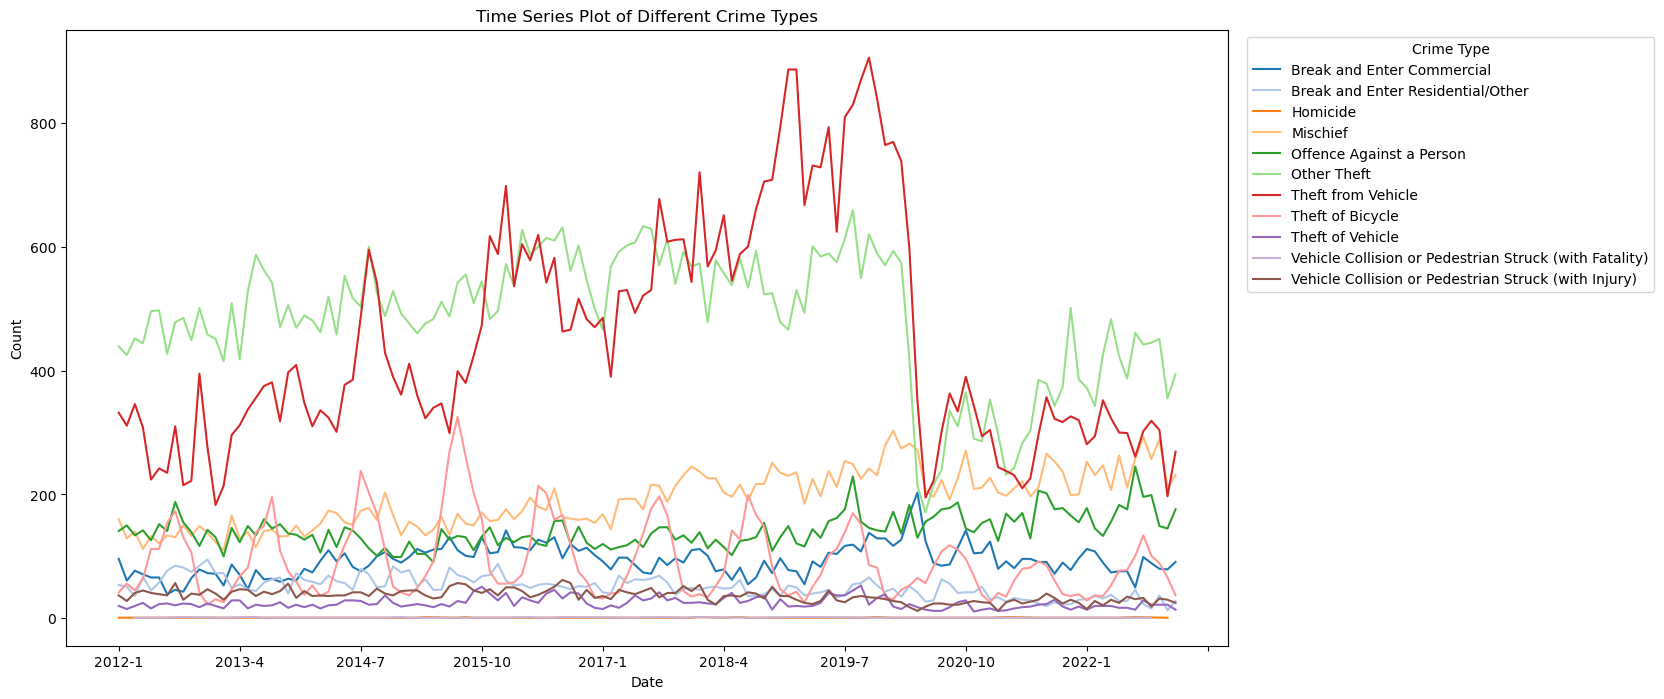

In [21]:
# Create a time series plot with multiple crime types (without points)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_central, x='DATE', y='COUNT', hue='TYPE', palette=color_palette)

# Set the x-axis date format and number of ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot of Different Crime Types')
plt.legend(title='Crime Type')

plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')

Plot smoothed time series plot of East area

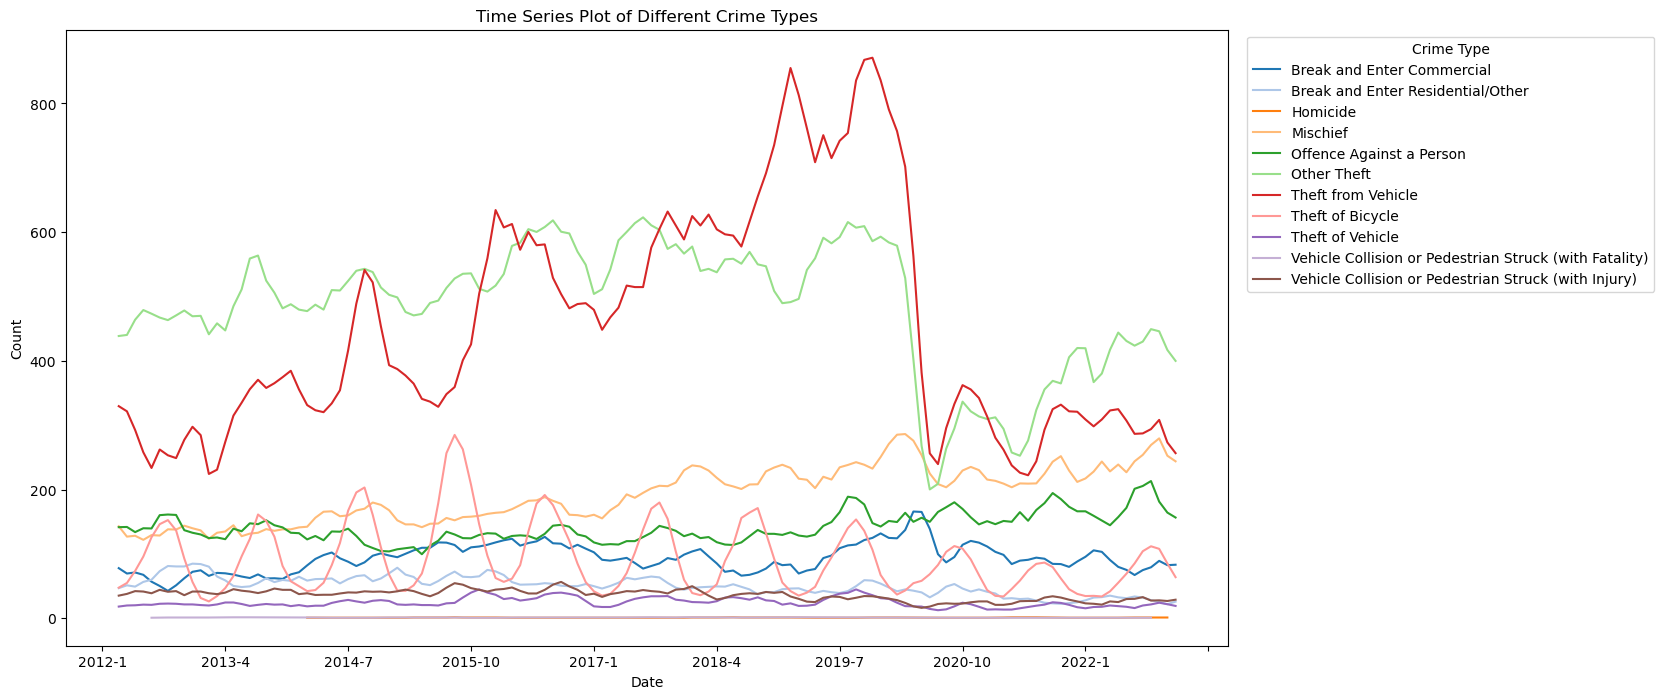

In [22]:
# Using moving average where lag = 3
df_central_smoothed = df_central.groupby(['TYPE']).rolling(window=3).mean()
df_central_smoothed.reset_index(inplace=True)

# Create a smoothed time series plot with multiple crime types (without points)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_central_smoothed, x='DATE', y='COUNT', hue='TYPE', palette=color_palette, estimator='mean')

# Set the x-axis date format and number of ticks
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Plot of Different Crime Types')
plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')

### 6. Conclusion

### 7. Limitation

### 8. Area for Further Reserch

### 9. References